# Grafana Logs - Feature Extraction

This notebook performs comprehensive feature extraction on preprocessed Grafana logs.

## Feature Categories:
1. **Categorical Encoding**: One-hot and label encoding for categorical variables
2. **Text Features**: Query pattern extraction and encoding
3. **Interaction Features**: Combinations of service, panel, and dashboard
4. **Aggregated Features**: Service-level and panel-level statistics
5. **Final Feature Matrix**: Prepared for clustering algorithms

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Preprocessed Data

In [2]:
# Load preprocessed data
df = pd.read_csv('../data/grafana_logs_preprocessed.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Loaded {len(df):,} records")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Loaded 149,999 records
Shape: (149999, 27)

Columns: ['timestamp', 'unix_timestamp', 'dashboard', 'panel', 'service', 'value', 'unit', 'environment', 'cluster', 'datasource', 'is_anomaly', 'anomaly_type', 'query', 'panel_type', 'visualization', 'hour', 'day_of_week', 'day_of_month', 'is_weekend', 'is_business_hours', 'hours_since_start', 'value_normalized', 'value_rolling_mean', 'value_rolling_std', 'value_rolling_min', 'value_rolling_max', 'value_deviation']


In [3]:
df.head()

,timestamp,unix_timestamp,dashboard,panel,service,value,unit,environment,cluster,datasource,...,day_of_month,is_weekend,is_business_hours,hours_since_start,value_normalized,value_rolling_mean,value_rolling_std,value_rolling_min,value_rolling_max,value_deviation
0,2024-01-01 00:00:26,1704047426,Database Metrics,Connection Pool Usage,api-gateway,32.39,percent,production,production-us-east-1,Prometheus,...,1,0,0,0.000000,-0.610049,-0.610049,0.000000,-0.610049,-0.610049,0.000000
1,2024-01-01 00:00:33,1704047433,Infrastructure Overview,Memory Usage,product-service,41.51,percent,production,production-us-east-1,Prometheus,...,1,0,0,0.001944,-0.303699,-0.303699,0.000000,-0.303699,-0.303699,0.000000
2,2024-01-01 00:00:46,1704047446,Cache Performance,Cache Hit Rate,api-gateway,89.10,percent,production,production-us-east-1,Prometheus,...,1,0,0,0.005556,1.294897,1.294897,0.000000,1.294897,1.294897,0.000000
3,2024-01-01 00:01:07,1704047467,JVM Metrics,GC Time,analytics-service,0.04,seconds,production,production-us-east-1,Prometheus,...,1,0,0,0.011389,-0.609923,-0.609923,0.000000,-0.609923,-0.609923,0.000000
4,2024-01-01 00:01:10,1704047470,Infrastructure Overview,Memory Usage,product-service,34.13,percent,production,production-us-east-1,Prometheus,...,1,0,0,0.012222,-0.551601,-0.427650,0.175293,-0.551601,-0.303699,-0.123951


## 2. Label Encoding for Categorical Variables

We'll use label encoding for high-cardinality categorical variables.

In [4]:
# Create a copy for feature extraction
df_features = df.copy()

# Categorical columns to encode
categorical_cols = ['dashboard', 'panel', 'service', 'unit', 'environment', 
                   'cluster', 'datasource', 'anomaly_type']

# Add panel_type and visualization if they exist
if 'panel_type' in df_features.columns:
    categorical_cols.extend(['panel_type', 'visualization'])

# Label encode categorical variables
label_encoders = {}
for col in categorical_cols:
    if col in df_features.columns:
        le = LabelEncoder()
        df_features[f'{col}_encoded'] = le.fit_transform(df_features[col].astype(str))
        label_encoders[col] = le
        print(f"{col}: {len(le.classes_)} unique values encoded")

print("\nLabel encoding completed!")

dashboard: 5 unique values encoded
panel: 12 unique values encoded
service: 7 unique values encoded
unit: 5 unique values encoded
environment: 1 unique values encoded
cluster: 1 unique values encoded
datasource: 1 unique values encoded
anomaly_type: 9 unique values encoded
panel_type: 2 unique values encoded
visualization: 2 unique values encoded

Label encoding completed!


## 3. Extract Query Pattern Features

Extract features from Prometheus query strings using pattern matching and TF-IDF.

In [5]:
import re

# Extract query patterns
def extract_query_features(query):
    if pd.isna(query):
        return {
            'has_rate': 0,
            'has_sum': 0,
            'has_avg': 0,
            'has_max': 0,
            'has_min': 0,
            'has_count': 0,
            'has_by_clause': 0,
            'has_time_range': 0,
            'query_length': 0
        }
    
    query_lower = str(query).lower()
    return {
        'has_rate': int('rate(' in query_lower),
        'has_sum': int('sum(' in query_lower or 'sum_' in query_lower),
        'has_avg': int('avg(' in query_lower or 'avg_' in query_lower),
        'has_max': int('max(' in query_lower or 'max_' in query_lower),
        'has_min': int('min(' in query_lower or 'min_' in query_lower),
        'has_count': int('count(' in query_lower or 'count_' in query_lower),
        'has_by_clause': int(' by(' in query_lower or ' by ' in query_lower),
        'has_time_range': int(bool(re.search(r'\[\d+[smhd]\]', query))),
        'query_length': len(query)
    }

# Apply query feature extraction
if 'query' in df_features.columns:
    query_features = df_features['query'].apply(extract_query_features)
    query_features_df = pd.DataFrame(query_features.tolist())
    
    # Add to main dataframe
    for col in query_features_df.columns:
        df_features[f'query_{col}'] = query_features_df[col]
    
    print("Query pattern features extracted!")
    print(f"\nQuery feature columns: {query_features_df.columns.tolist()}")
else:
    print("No 'query' column found. Skipping query feature extraction.")

Query pattern features extracted!

Query feature columns: ['has_rate', 'has_sum', 'has_avg', 'has_max', 'has_min', 'has_count', 'has_by_clause', 'has_time_range', 'query_length']


## 4. Create Interaction Features

Combine categorical variables to capture interactions.

In [6]:
# Create interaction features
df_features['service_panel'] = df_features['service'] + '_' + df_features['panel']
df_features['dashboard_panel'] = df_features['dashboard'] + '_' + df_features['panel']
df_features['service_dashboard'] = df_features['service'] + '_' + df_features['dashboard']

# Encode interactions
interaction_cols = ['service_panel', 'dashboard_panel', 'service_dashboard']
for col in interaction_cols:
    le = LabelEncoder()
    df_features[f'{col}_encoded'] = le.fit_transform(df_features[col])
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} unique combinations")

print("\nInteraction features created!")

service_panel: 84 unique combinations
dashboard_panel: 12 unique combinations
service_dashboard: 35 unique combinations

Interaction features created!


## 5. Aggregated Features

Create service-level and panel-level statistics.

In [7]:
# Service-level statistics
service_stats = df_features.groupby('service')['value_normalized'].agg([
    ('service_mean_value', 'mean'),
    ('service_std_value', 'std'),
    ('service_median_value', 'median'),
    ('service_min_value', 'min'),
    ('service_max_value', 'max')
]).reset_index()

df_features = df_features.merge(service_stats, on='service', how='left')

# Panel-level statistics
panel_stats = df_features.groupby('panel')['value_normalized'].agg([
    ('panel_mean_value', 'mean'),
    ('panel_std_value', 'std'),
    ('panel_median_value', 'median'),
    ('panel_min_value', 'min'),
    ('panel_max_value', 'max')
]).reset_index()

df_features = df_features.merge(panel_stats, on='panel', how='left')

# Dashboard-level statistics
dashboard_stats = df_features.groupby('dashboard')['value_normalized'].agg([
    ('dashboard_mean_value', 'mean'),
    ('dashboard_std_value', 'std')
]).reset_index()

df_features = df_features.merge(dashboard_stats, on='dashboard', how='left')

print("Aggregated features created!")
print(f"\nService statistics: {service_stats.shape}")
print(f"Panel statistics: {panel_stats.shape}")
print(f"Dashboard statistics: {dashboard_stats.shape}")

Aggregated features created!

Service statistics: (7, 6)
Panel statistics: (12, 6)
Dashboard statistics: (5, 3)


## 6. Create Deviation Features

Calculate how much each value deviates from group statistics.

In [8]:
# Deviation from service mean
df_features['deviation_from_service_mean'] = df_features['value_normalized'] - df_features['service_mean_value']

# Deviation from panel mean
df_features['deviation_from_panel_mean'] = df_features['value_normalized'] - df_features['panel_mean_value']

# Z-score within service
df_features['service_zscore'] = (df_features['value_normalized'] - df_features['service_mean_value']) / (df_features['service_std_value'] + 1e-10)

# Z-score within panel
df_features['panel_zscore'] = (df_features['value_normalized'] - df_features['panel_mean_value']) / (df_features['panel_std_value'] + 1e-10)

print("Deviation features created!")

Deviation features created!


## 7. Prepare Final Feature Matrix

Select and prepare features for clustering.

In [9]:
# Define feature columns for clustering
numeric_features = [
    'value_normalized',
    'hour', 'day_of_week', 'day_of_month', 'is_weekend', 'is_business_hours',
    'hours_since_start',
    'value_rolling_mean', 'value_rolling_std', 'value_rolling_min', 'value_rolling_max',
    'value_deviation',
    'service_mean_value', 'service_std_value', 'service_median_value',
    'panel_mean_value', 'panel_std_value', 'panel_median_value',
    'dashboard_mean_value', 'dashboard_std_value',
    'deviation_from_service_mean', 'deviation_from_panel_mean',
    'service_zscore', 'panel_zscore'
]

encoded_features = [
    'dashboard_encoded', 'panel_encoded', 'service_encoded', 'unit_encoded',
    'environment_encoded', 'cluster_encoded', 'datasource_encoded',
    'service_panel_encoded', 'dashboard_panel_encoded', 'service_dashboard_encoded'
]

# Add panel_type and visualization if they exist
if 'panel_type_encoded' in df_features.columns:
    encoded_features.extend(['panel_type_encoded', 'visualization_encoded'])

# Add query features if they exist
query_feature_cols = [col for col in df_features.columns if col.startswith('query_')]
if query_feature_cols:
    numeric_features.extend(query_feature_cols)

# Combine all features
all_feature_cols = numeric_features + encoded_features

# Filter to only existing columns
all_feature_cols = [col for col in all_feature_cols if col in df_features.columns]

print(f"Total features selected: {len(all_feature_cols)}")
print(f"Numeric features: {len([c for c in all_feature_cols if c in numeric_features])}")
print(f"Encoded features: {len([c for c in all_feature_cols if c in encoded_features])}")

Total features selected: 45
Numeric features: 33
Encoded features: 12


In [10]:
# Create feature matrix
X = df_features[all_feature_cols].copy()

# Handle any remaining missing values
X = X.fillna(0)

print(f"Feature matrix shape: {X.shape}")
print(f"Missing values: {X.isnull().sum().sum()}")
print(f"\nFeature matrix statistics:")
print(X.describe())

Feature matrix shape: (149999, 45)
Missing values: 0

Feature matrix statistics:
       value_normalized           hour    day_of_week   day_of_month  \
count      1.499990e+05  149999.000000  149999.000000  149999.000000   
mean      -6.669672e-17      11.517163       2.600604       5.000660   
std        1.000003e+00       6.918409       1.994261       2.709991   
min       -1.694704e+00       0.000000       0.000000       1.000000   
25%       -4.815766e-01       6.000000       1.000000       3.000000   
50%       -3.109240e-01      12.000000       2.000000       5.000000   
75%        2.784331e-01      18.000000       4.000000       7.000000   
max        4.697158e+00      23.000000       6.000000      10.000000   

          is_weekend  is_business_hours  hours_since_start  \
count  149999.000000      149999.000000      149999.000000   
mean        0.228968           0.375836         108.025391   
std         0.420170           0.484340          65.436102   
min         0.000000  

## 8. Feature Correlation Analysis

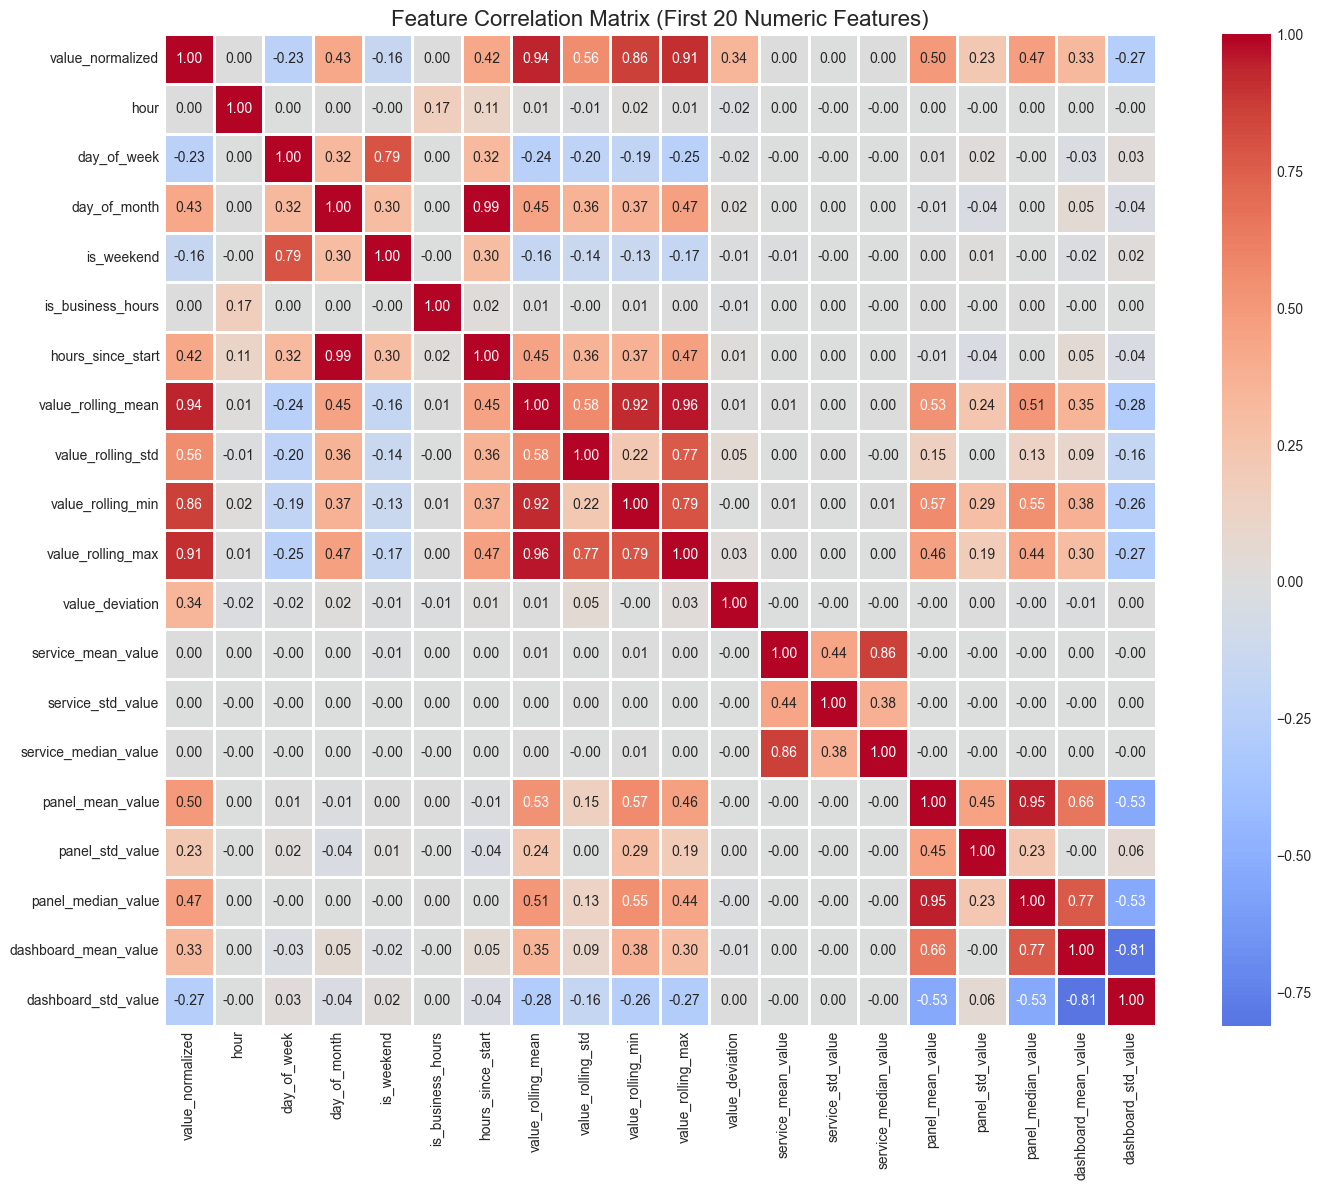

In [11]:
# Calculate correlation matrix for numeric features
numeric_cols = [col for col in all_feature_cols if col in numeric_features]
correlation_matrix = X[numeric_cols[:20]].corr()  # First 20 for visualization

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Matrix (First 20 Numeric Features)', fontsize=16)
plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis (using Random Forest)

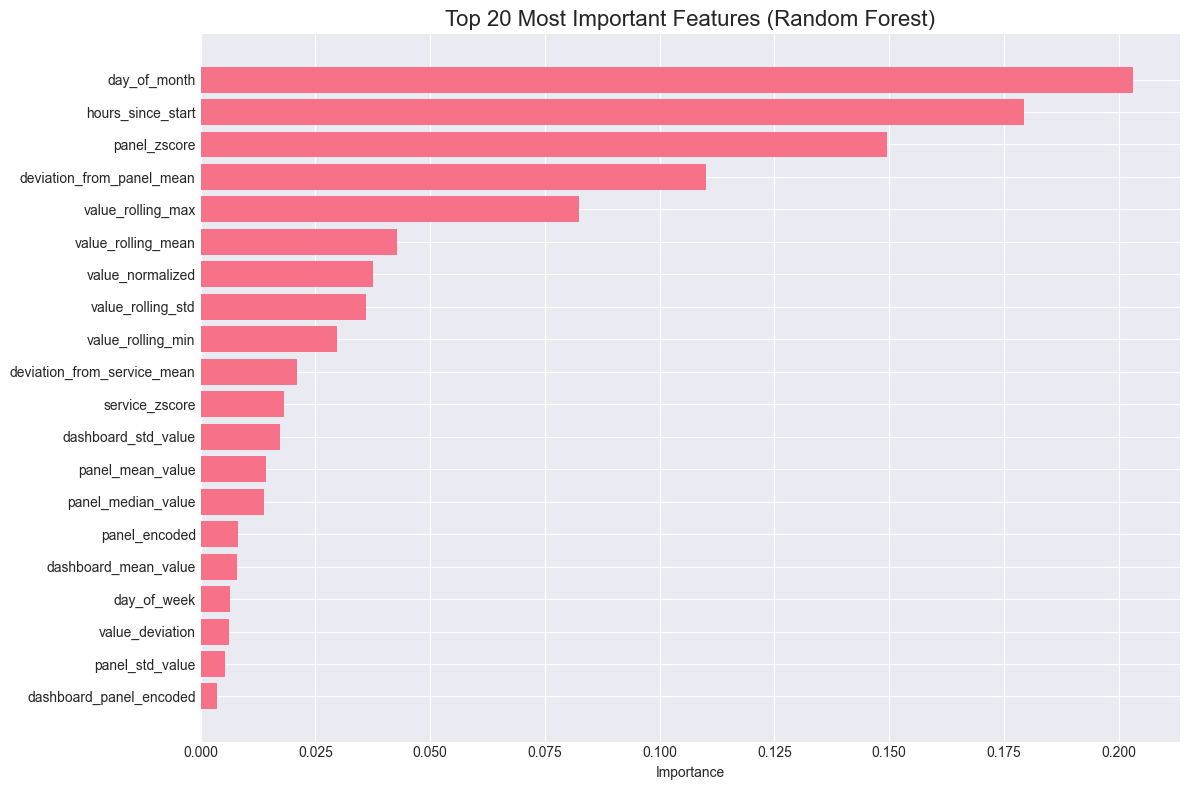


Top 10 Most Important Features:
                        feature  importance
3                  day_of_month    0.203214
6             hours_since_start    0.179402
23                 panel_zscore    0.149575
21    deviation_from_panel_mean    0.110004
10            value_rolling_max    0.082366
7            value_rolling_mean    0.042782
0              value_normalized    0.037606
8             value_rolling_std    0.035952
9             value_rolling_min    0.029805
20  deviation_from_service_mean    0.020981


In [12]:
from sklearn.ensemble import RandomForestClassifier

# Use anomaly label for feature importance if available
if 'is_anomaly' in df_features.columns:
    # Sample data for faster computation
    sample_size = min(10000, len(X))
    sample_indices = np.random.choice(len(X), sample_size, replace=False)
    
    X_sample = X.iloc[sample_indices]
    y_sample = df_features['is_anomaly'].iloc[sample_indices]
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_sample, y_sample)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': all_feature_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_20 = feature_importance.head(20)
    plt.barh(range(len(top_20)), top_20['importance'])
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Importance')
    plt.title('Top 20 Most Important Features (Random Forest)', fontsize=16)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

## 10. Dimensionality Visualization (PCA)

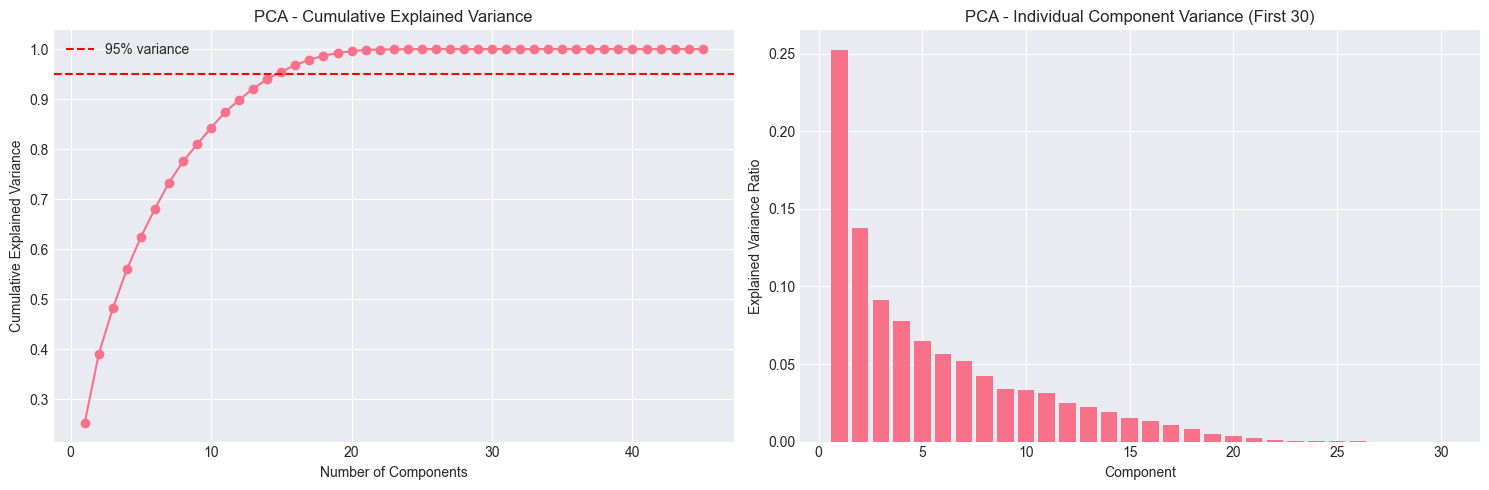


Number of components to explain 95% variance: 15


In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Cumulative explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
axes[0].plot(range(1, len(cumsum) + 1), cumsum, marker='o')
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('PCA - Cumulative Explained Variance')
axes[0].legend()
axes[0].grid(True)

# Individual explained variance (first 30 components)
axes[1].bar(range(1, min(31, len(pca.explained_variance_ratio_) + 1)), 
            pca.explained_variance_ratio_[:30])
axes[1].set_xlabel('Component')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('PCA - Individual Component Variance (First 30)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(cumsum >= 0.95) + 1
print(f"\nNumber of components to explain 95% variance: {n_components_95}")

## 11. Save Feature Matrix and Metadata

In [14]:
# Save feature matrix
X.to_csv('../data/feature_matrix.csv', index=False)
print(f"Feature matrix saved: {X.shape}")

# Save scaled feature matrix
X_scaled_df = pd.DataFrame(X_scaled, columns=all_feature_cols)
X_scaled_df.to_csv('../data/feature_matrix_scaled.csv', index=False)
print(f"Scaled feature matrix saved: {X_scaled_df.shape}")

# Save labels and metadata
metadata = df_features[['timestamp', 'is_anomaly', 'anomaly_type', 'service', 'panel', 'dashboard']].copy()
metadata.to_csv('../data/metadata.csv', index=False)
print(f"Metadata saved: {metadata.shape}")

# Save feature names
with open('../data/feature_names.txt', 'w') as f:
    f.write('\n'.join(all_feature_cols))
print(f"Feature names saved: {len(all_feature_cols)} features")

Feature matrix saved: (149999, 45)
Scaled feature matrix saved: (149999, 45)
Metadata saved: (149999, 6)
Feature names saved: 45 features


In [15]:
# Summary
print("=" * 80)
print("FEATURE EXTRACTION SUMMARY")
print("=" * 80)
print(f"Total records: {len(X):,}")
print(f"Total features: {len(all_feature_cols)}")
print(f"  - Numeric features: {len([c for c in all_feature_cols if c in numeric_features])}")
print(f"  - Encoded categorical features: {len([c for c in all_feature_cols if c in encoded_features])}")
print(f"\nFeature categories:")
print(f"  - Temporal: {len([c for c in all_feature_cols if any(x in c for x in ['hour', 'day', 'weekend', 'business'])])}")
print(f"  - Statistical: {len([c for c in all_feature_cols if any(x in c for x in ['rolling', 'mean', 'std', 'median'])])}")
print(f"  - Deviation: {len([c for c in all_feature_cols if 'deviation' in c or 'zscore' in c])}")
print(f"  - Query patterns: {len(query_feature_cols)}")
print(f"  - Interaction: {len([c for c in all_feature_cols if any(x in c for x in ['service_panel', 'dashboard_panel', 'service_dashboard'])])}")
print(f"\nData ready for clustering algorithms!")
print("=" * 80)

FEATURE EXTRACTION SUMMARY
Total records: 149,999
Total features: 45
  - Numeric features: 33
  - Encoded categorical features: 12

Feature categories:
  - Temporal: 6
  - Statistical: 14
  - Deviation: 5
  - Query patterns: 9
  - Interaction: 3

Data ready for clustering algorithms!
